# Getting started
___
The following illustrates the basic functionalities of the proteusAI package, such as training machine learning models using experimental data, performing zero-shot predictions and visualizing results. 

## Training models with experimental data
___

### 1.  Loading data from csv files

In [1]:
import sys
sys.path.append('../src/')
import proteusAI as pai

# will initiate storage space - else in memory
library = pai.Library(project='example_project', overwrite=False) 

# load data from csv or excel: x should be sequences, y should be labels, y_type class or num
library.read_data(data='demo_data/GB1_raw.csv', seqs='Sequence', y='Data', y_type='num', names='Description')

# compute and save ESM-2 representations at example_lib/representations/esm2
library.compute(method='esm2')

Library example_project already exists. Loading existing library...
Initializing library 'example_project'...
Done!
Loading library 'example_project'...
- Found representations of type 'esm2' in 'rep/esm2'.
- Found representations of type 'ohe' in 'rep/ohe'.
- Found representations of type 'blosum62' in 'rep/blosum62'.
- Found representations of type 'blosum50' in 'rep/blosum50'.
Loading done!
ohe representation 100.0 % computed.
blosum62 representation 100.0 % computed.
esm2 representation 100.0 % computed.
blosum50 representation 100.0 % computed.
computing 0 proteins


### 1.1 Loading data from fasta files (commented out because not used in example - but works)

remember to rename the files accordingly when reading the same data with different names to prevent redundant computations. Here the protein names are updated to the names in the csv file instead of the names in the fasta headers.

In [2]:
# read data from fasta files
#library.read_data(data='demo_data/GB1.fasta')

# rename proteins 
#names = []
#for prot in library.proteins:
#    name = prot.name.split('|')[1].replace('_', '+')
#    names.append(name)
    
#library.rename_proteins(names)

# compute and save ESM-2 representations at example_lib/representations/esm2
#library.compute(method='esm2')

### 2. Training models

In [3]:
# Choose model type, random forest, linear regression, svm, ...
model = pai.Model(model_type='rf')

# will save a model and report at models/rf/
model.train(library=library, x='esm2', split='random')

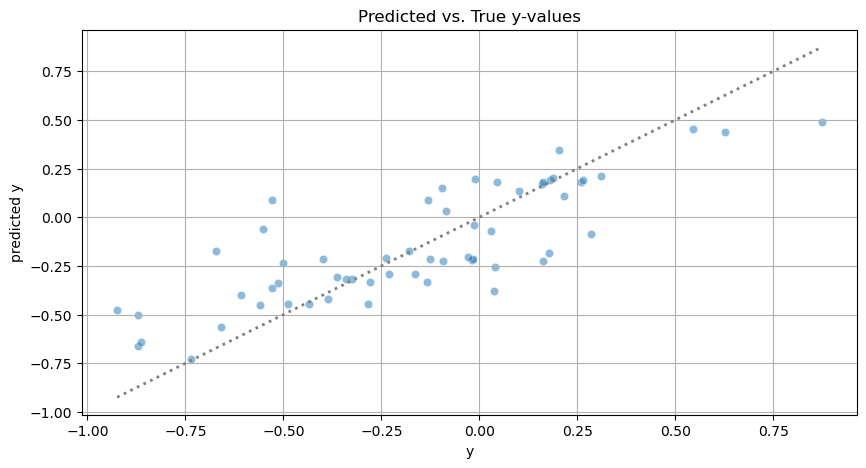

In [4]:
y_t = model.y_val
y_p = model.y_val_pred
model.true_vs_predicted(y_t, y_p, file='val_predicted_vs_true.png')

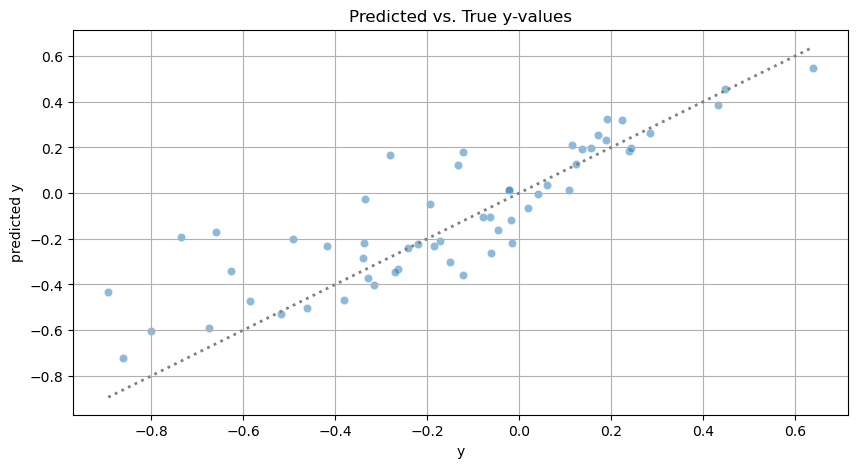

In [5]:
y_t = model.y_test
y_p = model.y_test_pred
model.true_vs_predicted(y_t, y_p)

### 3. Creating model ensembles

In [6]:
#ensemble = pai.Ensemble([model_1, model_2])

### 4. Loading existing libraries and models

In [7]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### 5. Making predictions

In [8]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### Visualizing library and model results

In [9]:
# create tSNE plot of esm2 representations, colored by class
#library.tsne(x='esm2', fname='path/to/plot/tSNE.png', show=True)

## Making zero-shot predictions
___
### 1. Creating a protein object

In [10]:
# loading a protein from a fasta file
protein = pai.Protein.load_fasta('demo_data/GB1_wt.fasta')
protein

proteusAI.Protein():
____________________
name	: GB1_wt
seq	: MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLCELPERQIHKIASALLAYARSIDNPSALQAAIRRMVLSHARAGVQAVHYPLYWECLRDAIKEVLGPDATETLLQAWKEAYDFLAHLLSTKEAQVYAVLAE
rep	: []
y	None

### 2. Create a library

In [11]:
# create a deep-mutational scanning library
#library = protein.DMS(name='dms')
#library

### Compute scores

In [12]:
# create zero-shot scores using the ESM-2 model and the masked-marginal probability metric
#library.zs_prediction(model='esm2', method='mmp')
#library

In [13]:
# inspect results
#scores = library.zs_scores()
#scores

## Training VAEs
___
### 1. loading MSA

In [14]:
# different formats can be provided 
#msa = pai.Library.load_msa(name='msa', data='msa.fasta')
#msa

### 2. Training a VAE

In [15]:
#vae = pai.Model(type='vae', layers=[2000, 1000, 500], z_dim=200)
#vae = vae.train(lib=msa)

### 3. Use the VAE to create representations

In [16]:
#msa.compute(method='vae', model=vae)

### 4. Finetune VAE

In [17]:
# load library with experimental data
#library = pai.Library.load(data='path/to/library')

# fine tune VAE
#model = pai.Model(lib=library, fine_tune=vae)

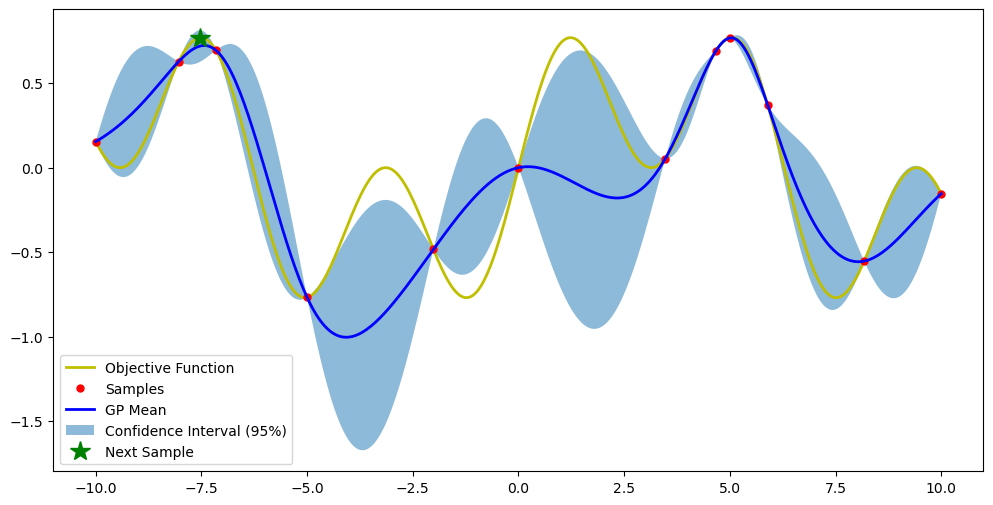

In [23]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the function to optimize
def objective_function(x):
    return np.sin(x) * np.cos(x/2)

# Initialization
X_sample = np.array([-5, 0, 5]).reshape(-1, 1)
Y_sample = objective_function(X_sample)

# Define the Gaussian Process
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    ''' 
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    '''
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample = gp.predict(X_sample)

    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)

    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.ravel()

def propose_location(acquisition, X_sample, Y_sample, gp):
    ''' 
    Proposes the next sampling point by optimizing the acquisition function.
    '''
    min_val = float('inf')
    min_x = None
    
    # Consider a grid of points for simplicity
    X = np.linspace(-10, 10, 1000).reshape(-1, 1)
    
    # Find the best point
    acq_values = acquisition(X, X_sample, Y_sample, gp)
    max_acq = np.max(acq_values)
    max_acq_idx = np.where(acq_values == max_acq)[0]
    
    if max_acq_idx.shape[0] > 0:
        min_x = X[max_acq_idx[0]]
        min_val = max_acq
    
    return min_x.reshape(-1, 1), min_val

# Bayesian optimization loop
n_iter = 10
for i in range(n_iter):
    # Update Gaussian Process with existing samples
    gp.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function
    X_next, acq_value = propose_location(expected_improvement, X_sample, Y_sample, gp)
    
    # Obtain next noisy sample from the objective function
    Y_next = objective_function(X_next)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

# Plotting the optimization process
plt.figure(figsize=(12, 6))
X = np.linspace(-10, 10, 400).reshape(-1, 1)
mu, std = gp.predict(X, return_std=True)

plt.plot(X, objective_function(X), 'y-', lw=2, label='Objective Function')
plt.plot(X_sample[:-1], Y_sample[:-1], 'r.', markersize=10, label='Samples')
plt.plot(X, mu, 'b-', lw=2, label='GP Mean')
plt.fill_between(X.ravel(), 
                 mu.ravel() - 1.96 * std, 
                 mu.ravel() + 1.96 * std, 
                 alpha=0.5, label='Confidence Interval (95%)')
plt.plot(X_sample[-1], Y_sample[-1], 'g*', markersize=15, label='Next Sample')
plt.legend()
plt.show()


In [26]:
X_sample

array([[ -5.        ],
       [  0.        ],
       [  5.        ],
       [  5.8958959 ],
       [  3.47347347],
       [-10.        ],
       [ 10.        ],
       [ -8.03803804],
       [ -2.01201201],
       [ -7.15715716],
       [  4.67467467],
       [  8.17817818],
       [ -7.53753754]])

In [25]:
X_next

array([[-7.53753754]])

In [29]:
# Import necessary libraries
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# Load the aligned sequences
alignment = AlignIO.read('../../../../Desktop/example.aln.clustal_num', 'clustal')

# Calculate the distance matrix
calculator = DistanceCalculator('identity')
distance_matrix = calculator.get_distance(alignment)

# Construct the phylogenetic tree using UPGMA algorithm
constructor = DistanceTreeConstructor()
tree = constructor.upgma(distance_matrix)

# Save the tree to a file
Phylo.write(tree, 'phylogenetic_tree.xml', 'phyloxml')

# Visualize the tree
Phylo.draw_ascii(tree)

            ________________ HDR7337683.1:1-214
         __|
        |  |________________ HDR5128327.1:1-213
        |
        |                            __ WP_243498389.1:1-216
        |                          _|
        |                     ____| |__ WP_210627890.1:1-216
        |                    |    |
        |                    |    |____ HDR3647977.1:1-216
        |                    |
        |                    |         __ WP_212804234.1:1-216
        |                 ___|       _|
        |                |   |      | |  , PGK36347.1:17-232
        |                |   |      | |__|
        |                |   | _____|    | WP_141547475.1:1-216
        |                |   ||     |
        |                |   ||     |    , PDY95449.1:17-232
        |                |   ||     |____|
        |                |    |          | WP_139303860.1:1-216
        |                |    |
        |                |    |________ MDA1521791.1:1-216
        |                |
